In [1]:
import gensim
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, Word2VecModel

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import numpy as np

In [2]:
PATH = './data/'
# spark = SparkSession.builder.master("local").appName("WikiParse").getOrCreate()
conf = SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '4G')
        .set('spark.driver.memory', '45G')
        .set('spark.driver.maxResultSize', '10G'))
sc = SparkContext(conf=conf)

### Save pyspark Word2Vec model to gensim format

In [3]:
def save_model(w2v_model, file_name):
    vectors = w2v_model.getVectors()
    size = len(vectors.first()['vector'])
    amount = vectors.count()

    vectors_collection = vectors.collect()

    f = open(file_name, 'w')

    f.write('{} {}\n'.format(amount, size))

    for row in vectors_collection:
        vec_str = ' '.join([ str(np.round(x, 5)) for x in row['vector']])
        f.write(row['word'] + ' ' + vec_str + '\n')

    f.close()


custom_models = dict()

In [16]:
# n = 11

# custom_model = Word2VecModel.load(PATH + "/w2v/word2vec_{}".format(n))
# print('Loaded Word2VecModel: {}'.format(n))
# save_model(custom_model, PATH + 'custom.embeddings.{}'.format(n))
# print('Saved: {}'.format(n))


### Read model by gensim

In [10]:
eta_model = gensim.models.KeyedVectors.load_word2vec_format(PATH+\
                                                            'ubercorpus.lowercased.tokenized.word2vec.300d.bz2')

/home/serhii/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
for load in [1,3,5,7,9,11]:
    custom_model = gensim.models.KeyedVectors.load_word2vec_format(PATH + 'custom.embeddings.{}'.format(load))
    print('Loaded Gensim: {}'.format(load))
    custom_models[load] = custom_model

/home/serhii/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loaded Gensim: 1
Loaded Gensim: 3
Loaded Gensim: 5
Loaded Gensim: 7
Loaded Gensim: 9
Loaded Gensim: 11


### Evaluate models

In [13]:
def test_model(model, num = 1000):
    
    total_num = 0
    counter = 0
    
    start = 21000
    
    s = 2000

    with open(PATH + 'test_vocabulary.txt') as f:
        lines = f.readlines()
        
        test_arr = lines[s:s+num] + lines[start:]

        for line in test_arr:
            test_words = line[:-1].lower().split('\t')
            if test_words[0][0] == ':':
                continue

            w1, w2, w3, w4 = tuple(test_words)

            if w1 in model and w2 in model and w3 in model and w4 in model:
                
                total_num += 1

                result = model.most_similar(positive=[w1, w4], negative=[w3])

                for r in result:
                    if r[0] == w2:
                        counter += 1
                        break
                    
    return np.round(counter / total_num, 4), counter, total_num, len(test_arr)

acc_result = []

for test in [1,3,5,7,9,11]:
    print(test, test_model(custom_models[test]))
    acc_result.append((test, test_model(custom_models[test])))

1 (0.094, 205, 2180, 3982)
3 (0.1754, 475, 2708, 3982)
5 (0.1702, 461, 2708, 3982)
7 (0.1617, 459, 2839, 3982)
9 (0.1997, 575, 2880, 3982)
11 (0.2292, 660, 2880, 3982)


In [14]:
acc_eta = test_model(eta_model)

### Plot results

In [61]:
g_data = {
    'models': [],
    'acc': [],
    'color': [],
    'vocab_size': [],
    'missed_words': []
}

for acc in acc_result:
    g_data['models'].append(acc[0])
    g_data['acc'].append(acc[1][0])
    g_data['vocab_size'].append(len(custom_models[acc[0]].wv.vocab))
    g_data['missed_words'].append( acc[1][3] - acc[1][2] )
    
    g_data['color'].append('#0000FF')
    
g_data['acc'].append(acc_eta[0])
g_data['models'].append(13)
g_data['color'].append('#FF0000')
g_data['vocab_size'].append(len(eta_model.wv.vocab))
g_data['missed_words'].append(acc_eta[3] - acc_eta[2])


/home/serhii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':
/home/serhii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Model accuracy depending on the number of articles

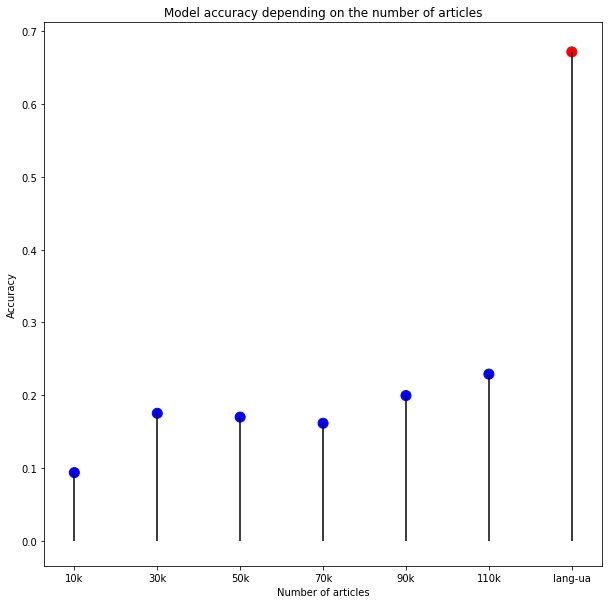

In [64]:
plt.figure(figsize=(10,10))
plt.vlines(g_data['models'], ymin =0, ymax = g_data['acc'])
plt.scatter(g_data['models'], g_data['acc'], color=g_data['color'], s=100)


plt.xticks(g_data['models'], ['10k', '30k', '50k', '70k', '90k', '110k', 'lang-ua'])

plt.title('Model accuracy depending on the number of articles')

plt.ylabel('Accuracy')

plt.xlabel('Number of articles')

plt.show()

### Model vocabulary size

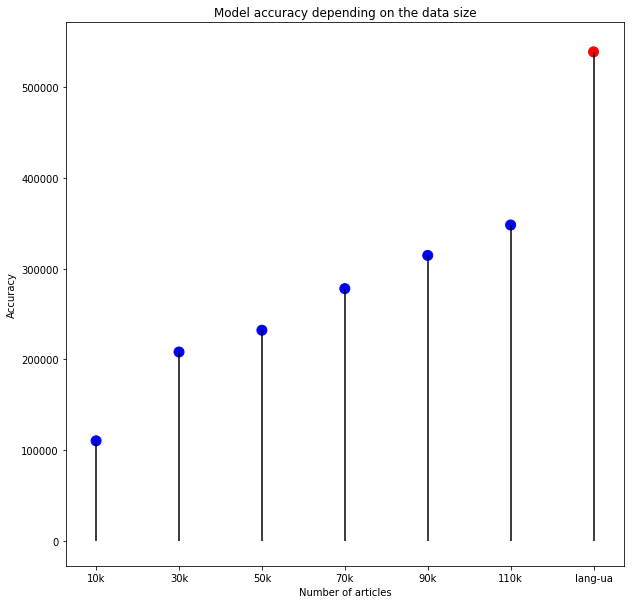

In [53]:
plt.figure(figsize=(10,10))
plt.vlines(g_data['models'], ymin =0, ymax = g_data['vocab_size'])
plt.scatter(g_data['models'], g_data['vocab_size'], color=g_data['color'], s=100)


plt.xticks(g_data['models'], ['10k', '30k', '50k', '70k', '90k', '110k', 'lang-ua'])

plt.title('Model vocabulary size')

plt.ylabel('Vocabulary size')

plt.xlabel('Number of articles')

plt.show()

### Model word absence

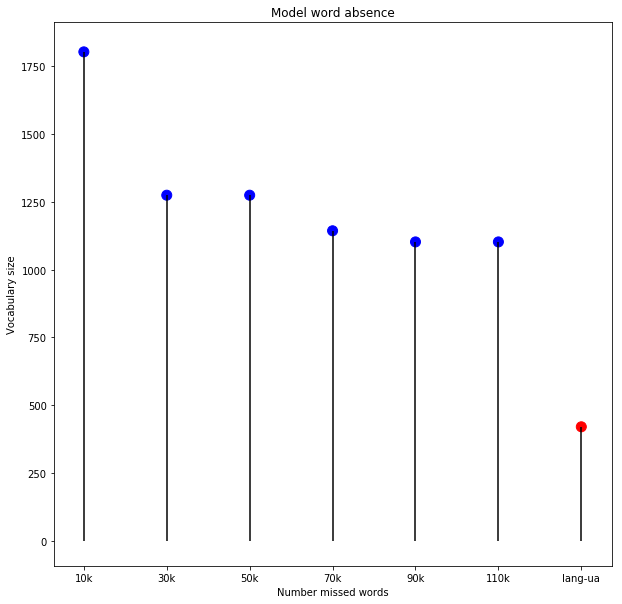

In [63]:
plt.figure(figsize=(10,10))
plt.vlines(g_data['models'], ymin =0, ymax = g_data['missed_words'])
plt.scatter(g_data['models'], g_data['missed_words'], color=g_data['color'], s=100)


plt.xticks(g_data['models'], ['10k', '30k', '50k', '70k', '90k', '110k', 'lang-ua'])

plt.title('Model word absence')

plt.ylabel('Vocabulary size')

plt.xlabel('Number missed words')

plt.show()